In [1]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import wandb
import numpy as np
from src.utils.util import ShellColor as sc

print(f"{sc.COLOR_PURPLE}Gym version:{sc.ENDC} {gym.__version__}")
print(f"{sc.COLOR_PURPLE}Pytorch version:{sc.ENDC} {torch.__version__}")

from src.agents.dqn_agent import DQNAgent
from src.utils import util as rl_util

Gym version: 0.27.0
Pytorch version: 1.12.0+cu113


In [2]:
env_name = "PongNoFrameskip-v4"
env = gym.make(env_name)
env = gym.wrappers.AtariPreprocessing(
    env=env, 
    terminal_on_life_loss=True, 
    grayscale_obs=True, 
    scale_obs=False,
    noop_max=30)
env = gym.wrappers.FrameStack(env, num_stack=4)
rl_util.print_env_info(env=env)


============ Env Info ===========
Env id: PongNoFrameskip-v4
Observation space size: (4, 84, 84)
Action space size: 6
Action list: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


(4, 84, 84)


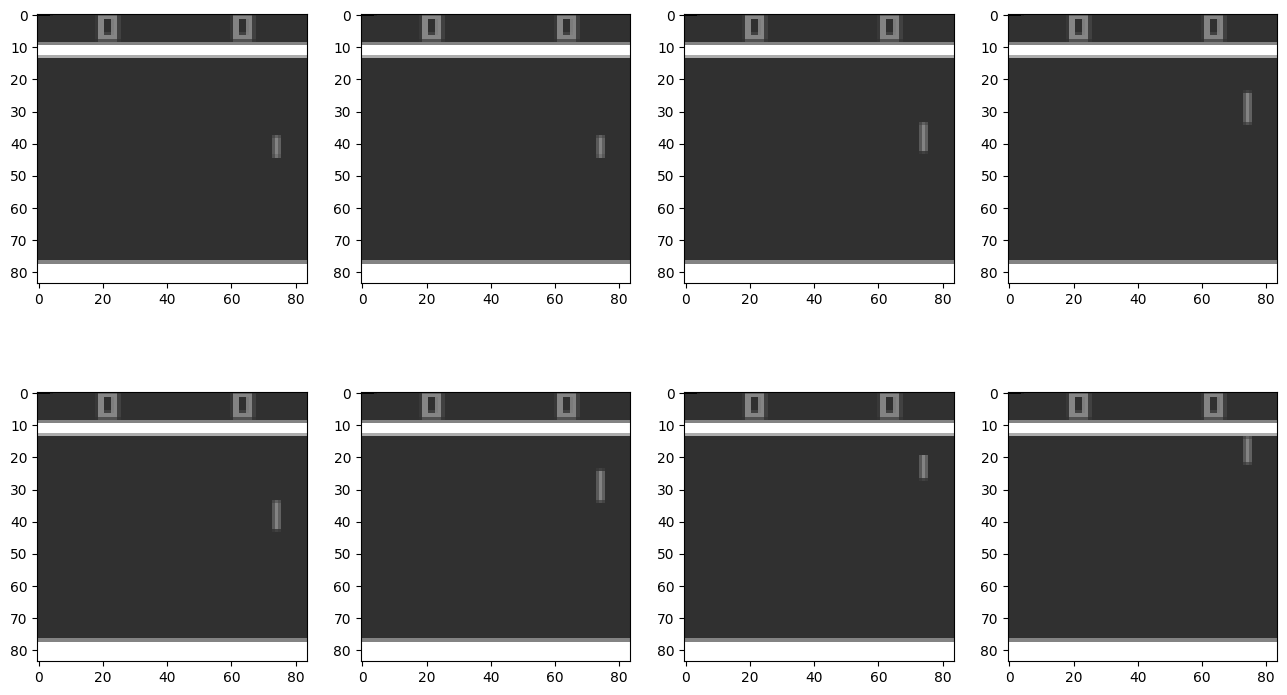

In [3]:
stacked_obs, info = env.reset()
print(stacked_obs.shape)
n_cols = 4
n_rows = 2
fig = plt.figure(figsize=(16, 9))
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(stacked_obs[col], cmap="gray")
        stacked_obs, _, _, _,_ = env.step(env.action_space.sample())
plt.show()

In [4]:
config = rl_util.create_config()
config["seed"]=42
config["print_frequency"] = 10

In [5]:
agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=True,
    config=config,
)

print(agent.config)
print(type(agent.memory))

Model Initializing... An input shape is (4, 84, 84)
Model Initializing... An input shape is (4, 84, 84)
========== Config Info ==========
n_episodes: 1000
max_steps: 2000000
batch_size: 32
gamma: 0.99
lr: 0.0001
start_training_step: 10000
learning_frequency: 1
epsilon_start: 1
epsilon_end: 0.01
epsilon_decay: 300000.0
seed: 42
target_update_frequency: 1000
buffer_size: 50000
device: cuda:0
mean_reward_bound: 10
print_frequency: 10
<class 'src.commons.memory.replay_memory.ReplayMemory'>


In [6]:
save_dir = "result/DDQN/atari/"
rl_util.create_directory(save_dir)
current_time = rl_util.get_current_time_string()
save_model_name = save_dir + env_name + "_" + current_time+".pt"

In [7]:
save_model_name

'result/DDQN/atari/PongNoFrameskip-v4_2023_02_17_05_09_15.pt'

In [8]:
obs, _ =  env.reset()
episode_returns = []
episode_return = 0
episode_losses = []
episode_loss = 0
episode = 0
best_mean_return = -10000
is_start_train = True

for t in range(agent.config.max_steps):
    epsilon = agent.decay_epsilon(t)
    action = agent.select_action(obs, epsilon)
    next_obs, reward, done, _, _ = env.step(action)
    agent.store_transition(obs, action, reward, next_obs, done)
    episode_return += reward
    
    if t > agent.config.start_training_step:
        if is_start_train:
            print(f"Start Training at timestep {t}...")
            is_start_train = False
            
        episode_loss += agent.update()
        if t % agent.config.target_update_frequency == 0:
            agent.update_target_network()

    if done:
        obs, _ = env.reset()
        episode += 1
        episode_returns.append(episode_return)
        episode_losses.append(episode_loss)

        if episode % agent.config.print_frequency == 0:
            mean_episode_return = np.mean(episode_returns[-100:])
            print("*" * 40)
            print(f"steps: {t}")
            print(f"episode: {episode}")
            print(f"mean 100 episode return: {mean_episode_return:.2f}")
            print(f"loss: {episode_loss}")
            print(f"epsilon: {epsilon:.2f}")
            print("*" * 40)

            # wandb.log({
            #     "episode": episode+1,
            #     "mean return": mean_episode_return,
            #     "epsilon": np.round(epsilon, 2)
            # })

            if best_mean_return < mean_episode_return:
                torch.save(agent.policy_network.state_dict(), save_model_name)
                print(f"Best mean reward updated {best_mean_return:.3f} -> {mean_episode_return:.3f}, model saved")
                best_mean_return = mean_episode_return
                if mean_episode_return > 10:
                    print(f"Solved!")
                    break
                
        episode_return = 0
        episode_loss = 0
    else:
        obs = next_obs

****************************************
steps: 9008
episode: 10
mean 100 episode return: -20.70
loss: 0
epsilon: 0.97
****************************************
Best mean reward updated -10000.000 -> -20.700, model saved
Start Training at timestep 10001...
****************************************
steps: 18902
episode: 20
mean 100 episode return: -20.30
loss: 10.224943646004249
epsilon: 0.94
****************************************
Best mean reward updated -20.700 -> -20.300, model saved
****************************************
steps: 28478
episode: 30
mean 100 episode return: -20.27
loss: 6.656699126207968
epsilon: 0.91
****************************************
Best mean reward updated -20.300 -> -20.267, model saved
****************************************
steps: 37557
episode: 40
mean 100 episode return: -20.27
loss: 4.648649007867789
epsilon: 0.87
****************************************
****************************************
steps: 47235
episode: 50
mean 100 episode return: -20.16


KeyboardInterrupt: 

In [ ]:
fig, ax = rl_util.init_2d_figure("Reward")
rl_util.plot_graph(
    ax,
    episode_returns,
    title="reward",
    ylabel="reward",
    save_dir_name=save_dir,
    is_save=True,
)
rl_util.show_figure()
fig, ax = rl_util.init_2d_figure("Loss")
rl_util.plot_graph(
    ax, episode_losses, title="loss", ylabel="loss", save_dir_name=save_dir, is_save=True
)
rl_util.show_figure()

In [ ]:
env = gym.make(env_name, render_mode="human")
env = gym.wrappers.AtariPreprocessing(env=env, terminal_on_life_loss=True, grayscale_obs=True,
                                            noop_max=0)
env = gym.wrappers.FrameStack(env, num_stack=4)

test_agent = DQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=True,
    config=config
)
test_agent.policy_network.load_state_dict(torch.load(save_model_name))

for i_episode in range(1):
    state, _ = env.reset()
    test_reward = 0
    while True:
        env.render()
        action = test_agent.select_action(state, 0.)
        next_state, reward, terminated, truncated, _ = env.step(action)
        test_reward += reward
        state = next_state
        done = terminated or truncated
        if done:
            break
    print(f"{i_episode} episode Total Reward: {test_reward}")
env.close()